In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from pydub import AudioSegment
import warnings
warnings.filterwarnings('ignore')
import joblib

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix, multilabel_confusion_matrix

In [3]:
directory_path = 'DATA_SET'

In [4]:
def convert_m4a_to_wav(mp3_path):
    wav_path = mp3_path.replace('.m4a', '.wav')
    audio = AudioSegment.from_file(mp3_path, format="m4a")
    audio.export(wav_path, format="wav")
    return wav_path

In [5]:
paths = []
labels = []

if os.path.exists(directory_path):
    for dirname, _, filenames in os.walk(directory_path):
        for filename in filenames:
            file_path = os.path.join(dirname, filename)
            wav_file_path =convert_m4a_to_wav(file_path)
            category = os.path.basename(dirname)  
            paths.append(wav_file_path)
            labels.append(category)

    print(f'Dataset Loaded: {len(paths)} files found.')


    df = pd.DataFrame({'file_path': paths, 'label': labels})
else:
    print('Directory does not exist.')


Dataset Loaded: 516 files found.


In [6]:
df.tail(10)

,file_path,label
506,DATA_SET\sad\Sad 50.wav,sad
507,DATA_SET\sad\Sad 50.wav,sad
508,DATA_SET\sad\Sad 6.wav,sad
509,DATA_SET\sad\Sad 6.wav,sad
510,DATA_SET\sad\Sad 7.wav,sad
511,DATA_SET\sad\Sad 7.wav,sad
512,DATA_SET\sad\Sad 8.wav,sad
513,DATA_SET\sad\Sad 8.wav,sad
514,DATA_SET\sad\Sad 9.wav,sad
515,DATA_SET\sad\Sad 9.wav,sad


In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
df['label'].unique()

array(['noise', 'sad', 'disgust', 'happy', 'anger'], dtype=object)

<Axes: xlabel='label', ylabel='count'>

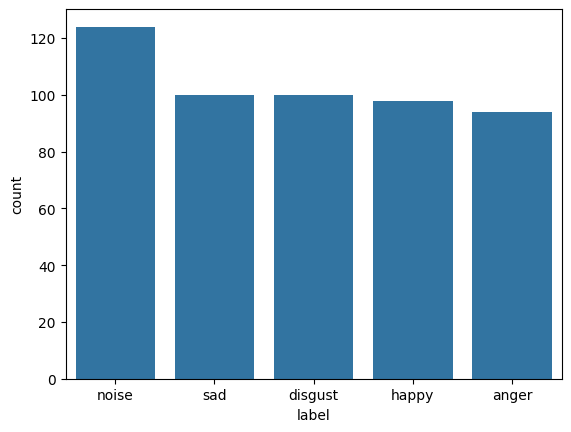

In [9]:
sns.countplot(data=df, x='label')

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

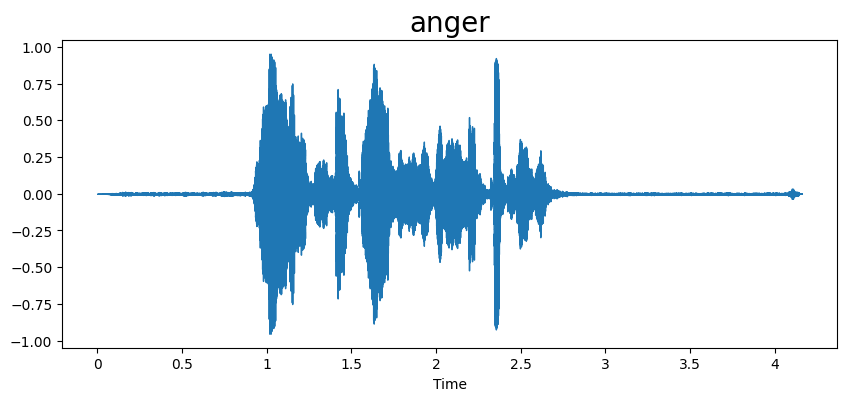

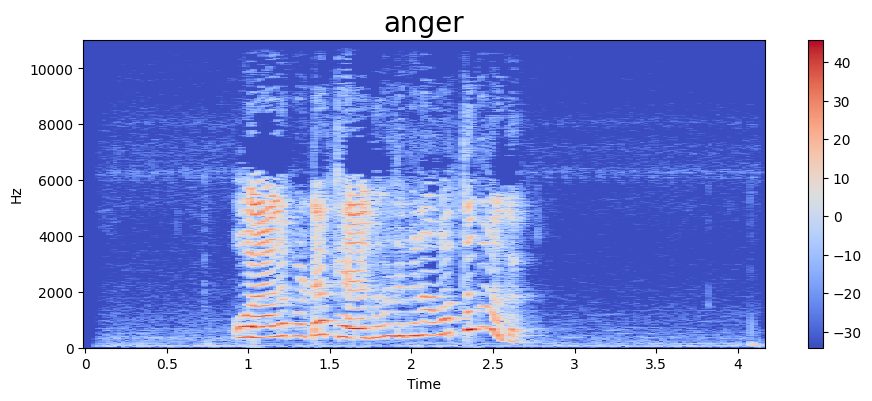

In [11]:
emotion = 'anger'
path = np.array(df['file_path'][df['label']==emotion])[5]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [12]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [13]:
extract_mfcc(df['file_path'][0])

array([-206.36923   ,  161.66637   ,  -35.044083  ,   58.7182    ,
        -38.235443  ,   19.39993   ,  -34.174244  ,    8.168228  ,
         -6.674696  ,    9.263391  ,   -3.9342313 ,   -8.273388  ,
         10.049527  ,   -4.771414  ,    8.717982  ,  -18.221329  ,
          2.5264432 ,  -11.251724  ,   -0.31204847,   -3.1586063 ,
         -3.0169435 ,   -0.8803768 ,   -5.600768  ,    3.992993  ,
         -6.774401  ,    4.4849243 ,   -2.488182  ,    2.9414089 ,
         -1.9243172 ,    2.8678412 ,   -1.733405  ,   -1.1324253 ,
          3.0810852 ,   -3.6695335 ,    0.73720133,   -3.4039524 ,
          2.166757  ,   -4.296228  ,    2.6864018 ,   -2.531166  ],
      dtype=float32)

In [14]:
X_mfcc = df['file_path'].apply(lambda x: extract_mfcc(x))

In [15]:
type(X_mfcc)

pandas.core.series.Series

In [16]:
X_mfcc[0:3]

0    [-206.36923, 161.66637, -35.044083, 58.7182, -...
1    [-305.61407, 110.87373, 2.1224747, 32.073368, ...
2    [-326.89743, 97.61809, 1.5651609, 36.361164, -...
Name: file_path, dtype: object

In [17]:
X_mfcc.shape

(516,)

In [18]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(516, 40)

In [19]:
X[0]

array([-206.36923   ,  161.66637   ,  -35.044083  ,   58.7182    ,
        -38.235443  ,   19.39993   ,  -34.174244  ,    8.168228  ,
         -6.674696  ,    9.263391  ,   -3.9342313 ,   -8.273388  ,
         10.049527  ,   -4.771414  ,    8.717982  ,  -18.221329  ,
          2.5264432 ,  -11.251724  ,   -0.31204847,   -3.1586063 ,
         -3.0169435 ,   -0.8803768 ,   -5.600768  ,    3.992993  ,
         -6.774401  ,    4.4849243 ,   -2.488182  ,    2.9414089 ,
         -1.9243172 ,    2.8678412 ,   -1.733405  ,   -1.1324253 ,
          3.0810852 ,   -3.6695335 ,    0.73720133,   -3.4039524 ,
          2.166757  ,   -4.296228  ,    2.6864018 ,   -2.531166  ],
      dtype=float32)

In [20]:
X = np.expand_dims(X, -1)
X.shape

(516, 40, 1)

In [21]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[["label"]])

In [22]:
joblib.dump(enc, 'encoder.pkl')

['encoder.pkl']

In [50]:
category_enc = joblib.load("encoder.pkl")

labels_mapping = category_enc.categories_[0]

print("Label to column index mapping:")
for idx, label in enumerate(labels_mapping):
    print(f"{idx} → {label}")

Label to column index mapping:
0 → anger
1 → disgust
2 → happy
3 → noise
4 → sad


In [23]:
y = y.toarray()

In [24]:
y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [25]:
y.shape

(516, 5)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = Sequential()

model.add(LSTM(256, return_sequences=False, input_shape=(40, 1)))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,669 (1.17 MB)

 Trainable params: 305,669 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
X_train.shape, y_train.shape

((412, 40, 1), (412, 5))

In [31]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

In [32]:
y_train.shape

(412, 5)

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[early_stop])

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.3333 - loss: 1.5279 - val_accuracy: 0.4423 - val_loss: 1.2972
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4490 - loss: 1.2416 - val_accuracy: 0.4327 - val_loss: 1.1833
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5550 - loss: 1.0134 - val_accuracy: 0.5865 - val_loss: 1.0423
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5572 - loss: 1.0173 - val_accuracy: 0.5288 - val_loss: 0.9765
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5636 - loss: 0.9888 - val_accuracy: 0.6154 - val_loss: 0.9151
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6230 - loss: 0.9012 - val_accuracy: 0.6250 - val_loss: 0.8787
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.6805 - loss: 0.7558 - val_accuracy: 0.6635 - val_loss: 0.8745
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6877 - loss: 0.7670 - val_accuracy: 0.7212 - v

In [34]:
model.save('final_model.h5')

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

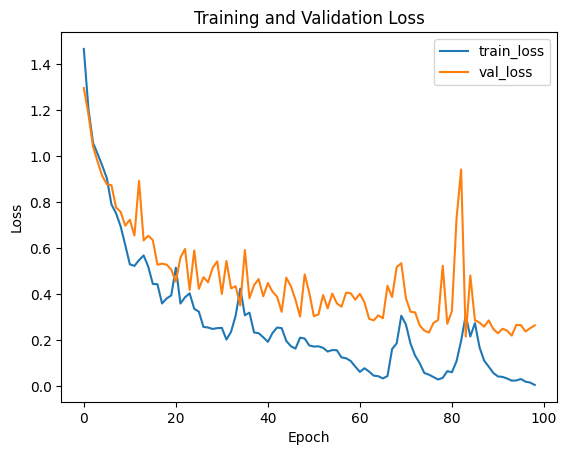

In [36]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
predictions = model.predict(X_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


In [38]:
predictions = predictions.round()

In [39]:
predictions


array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0.

In [40]:
y_val

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0.

In [41]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        23
           1       1.00      0.61      0.76        23
           2       0.94      0.79      0.86        19
           3       0.87      1.00      0.93        20
           4       0.83      1.00      0.90        19

   micro avg       0.88      0.87      0.87       104
   macro avg       0.90      0.87      0.87       104
weighted avg       0.90      0.87      0.87       104
 samples avg       0.87      0.87      0.87       104



In [42]:
cm_matrices = multilabel_confusion_matrix(y_val, predictions)
cm_matrices

array([[[77,  4],
        [ 1, 22]],

       [[81,  0],
        [ 9, 14]],

       [[84,  1],
        [ 4, 15]],

       [[81,  3],
        [ 0, 20]],

       [[81,  4],
        [ 0, 19]]])

In [43]:
def plot_multilabel_confusion_matrices(y_true, y_pred, classes):

    cm_matrices = multilabel_confusion_matrix(y_true, y_pred)
    num_classes = len(classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 4, 4))
    
    if num_classes == 1:
        axes = [axes]  
    
    for i, cm in enumerate(cm_matrices):
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=ax)
        ax.set_title(classes[i])
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    
    plt.tight_layout()
    plt.show()

In [44]:
df["label"].unique()

array(['noise', 'sad', 'disgust', 'happy', 'anger'], dtype=object)

In [51]:
classes = ['anger', 'disgust', 'happy', 'noise', 'sad']

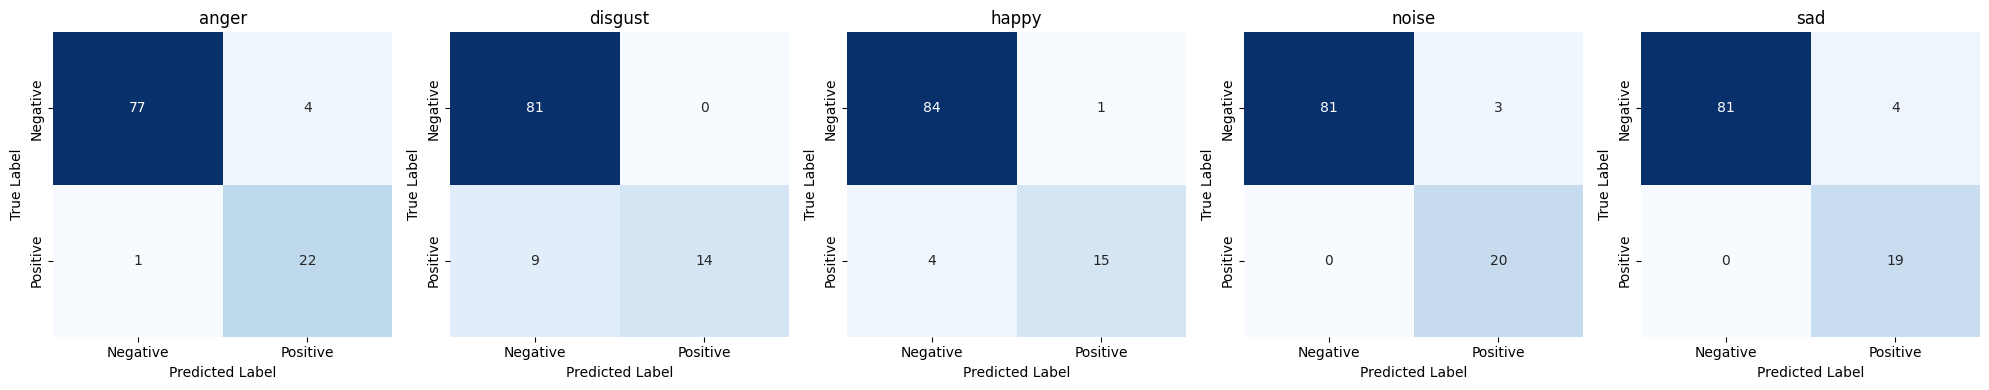

In [52]:
plot_multilabel_confusion_matrices(y_val, predictions, classes)

In [53]:
def plot_confusion_matrix1(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



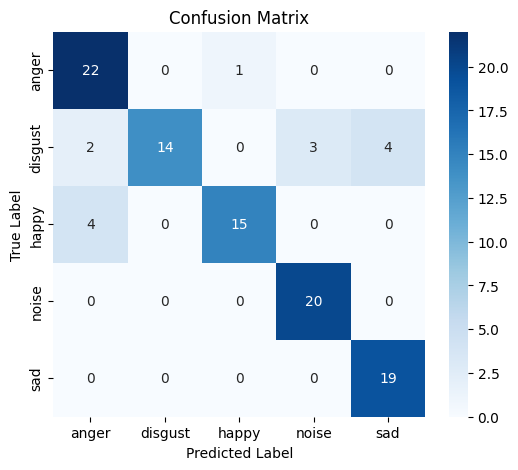

In [54]:
plot_confusion_matrix1(np.argmax(y_val, axis=1), np.argmax(predictions, axis=1), classes)

### Hyperparameter Tuning

In [81]:
def build_model(hp):
    model = Sequential()
    
    
    model.add(LSTM(hp.Int('lstm_units', min_value=64, max_value=512, step=64), 
                   return_sequences=False, input_shape=(40, 1)))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    
    model.add(Dense(hp.Int('dense_units1', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units2', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout3', 0.1, 0.5, step=0.1)))

    
    model.add(Dense(5, activation='softmax'))

    
    lr = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    
    return model

In [82]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=2,  
    directory='hyperparam_tuning',
    project_name='lstm_tuning'
)

In [83]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

Trial 10 Complete [00h 06m 38s]
val_accuracy: 0.8653846383094788

Best val_accuracy So Far: 0.932692289352417
Total elapsed time: 00h 44m 09s


In [84]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Dense Layer 1 Units: {best_hps.get('dense_units1')}")
print(f"Best Dense Layer 2 Units: {best_hps.get('dense_units2')}")
print(f"Best Dropout Rates: {best_hps.get('dropout1')}, {best_hps.get('dropout2')}, {best_hps.get('dropout3')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Best LSTM Units: 448
Best Dense Layer 1 Units: 256
Best Dense Layer 2 Units: 32
Best Dropout Rates: 0.1, 0.1, 0.1
Best Learning Rate: 0.001


In [85]:
best_model = tuner.hypermodel.build(best_hps)

In [86]:
history_best_model = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[early_stop])

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.4296 - loss: 1.4446 - val_accuracy: 0.3750 - val_loss: 1.3166
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.4781 - loss: 1.1274 - val_accuracy: 0.5673 - val_loss: 1.0201
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5958 - loss: 0.9021 - val_accuracy: 0.6250 - val_loss: 0.8555
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.6248 - loss: 0.8815 - val_accuracy: 0.6442 - val_loss: 0.8508
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.6107 - loss: 0.9535 - val_accuracy: 0.6923 - val_loss: 0.7212
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.7128 - loss: 0.7349 - val_accuracy: 0.6923 - val_loss: 0.6862
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.7457 - loss: 0.6103 - val_accuracy: 0.6731 - val_loss: 0.7131
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.7901 - loss: 0.5337 - val_accu

In [87]:
predictions_best_model = best_model.predict(X_val).round()

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step WARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000232DD638680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


In [88]:
print(classification_report(y_val,predictions_best_model))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90        23
           1       0.92      0.96      0.94        23
           2       0.90      1.00      0.95        19
           3       1.00      1.00      1.00        20
           4       0.95      1.00      0.97        19

   micro avg       0.95      0.95      0.95       104
   macro avg       0.95      0.96      0.95       104
weighted avg       0.96      0.95      0.95       104
 samples avg       0.95      0.95      0.95       104



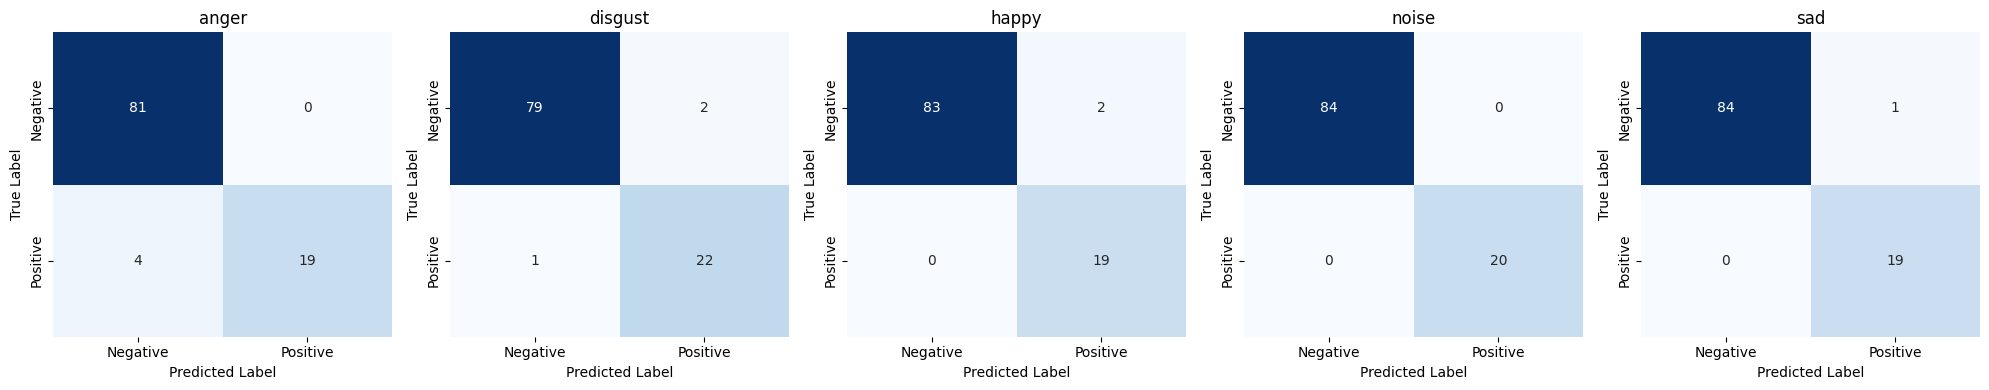

In [89]:
plot_multilabel_confusion_matrices(y_val, predictions_best_model, classes)

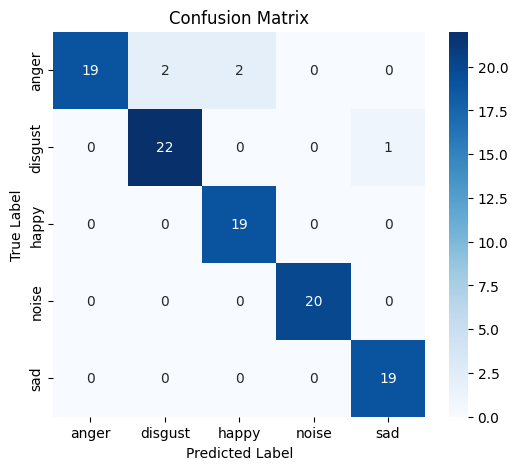

In [90]:
plot_confusion_matrix1(np.argmax(y_val, axis=1), np.argmax(predictions_best_model, axis=1), classes)

In [98]:
best_model.save('final_best_model.h5')